In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/COMP 8740/Sensorless drive/'
%ls

/content/drive/MyDrive/COMP 8740/Sensorless drive
 Extra/             Final_2_Results/  'Old Final'/
 Final_1.ipynb      Final_3.ipynb      Sensorless_drive_diagnosis.txt
 Final_1_Results/   Final_3_Results/
 Final_2.ipynb      Final_Scripts/


In [3]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [4]:
col_names = [f'feat{i+1}' for i in range(48)] + ['class']
df = pd.read_csv('Sensorless_drive_diagnosis.txt', header=None, names=col_names, sep=' ')
le = LabelEncoder()
df['class_enc'] = le.fit_transform(df['class'])

In [5]:
target_names = [str(c) for c in le.classes_]

In [6]:
class_counts = df['class_enc'].value_counts().sort_index()
class_counts

,count
class_enc,
0,5319
1,5319
2,5319
3,5319
4,5319
5,5319
6,5319
7,5319
8,5319


# Visualization of Dataset

In [7]:
X = df.drop(columns=['class', 'class_enc'])
y = df['class_enc']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# filtering outliers
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
Q1 = np.percentile(X_pca, 25, axis=0)
Q3 = np.percentile(X_pca, 75, axis=0)

IQR = Q3 - Q1
mask = np.all((X_pca >= Q1 - 1.5 * IQR) & (X_pca <= Q3 + 1.5 * IQR), axis=1)

X_filtered = X_scaled[mask]
y_filtered = y[mask]
y_filtered = y_filtered.reset_index(drop=True)

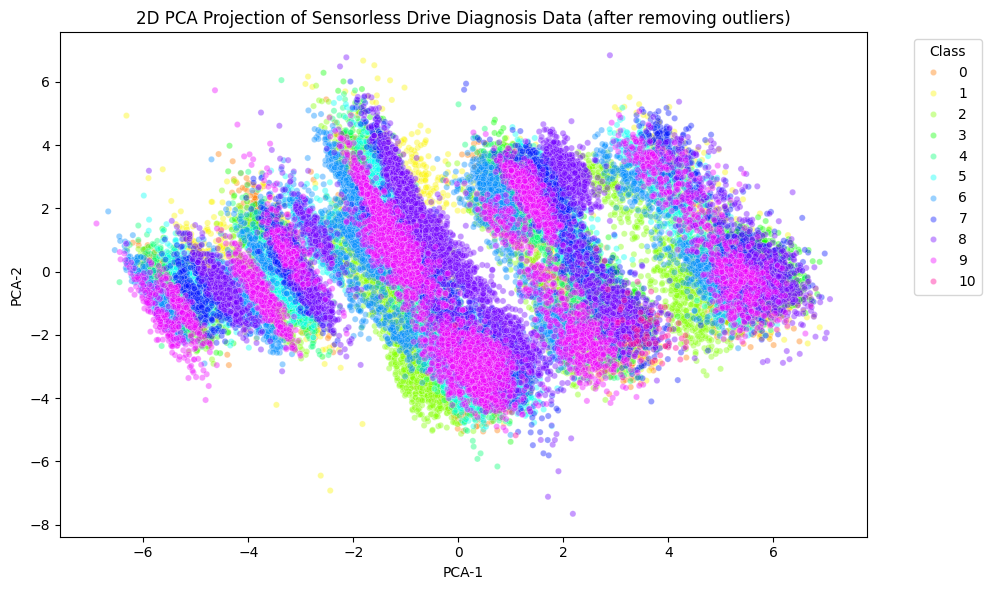

In [9]:
# reducing the dimension of 3D X_filtered to 2D for visualization with PCA
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_filtered)

df_pca_2d = pd.DataFrame(X_pca_2d, columns=['PCA-1', 'PCA-2'])
df_pca_2d['Class'] = y_filtered

plt.figure(figsize=(10, 6))
palette = sns.color_palette('hsv', n_colors=11)
sns.scatterplot(x='PCA-1', y='PCA-2', hue='Class', palette=palette, data=df_pca_2d, legend='full', s=20, alpha=0.4)
plt.title("2D PCA Projection of Sensorless Drive Diagnosis Data (after removing outliers)")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


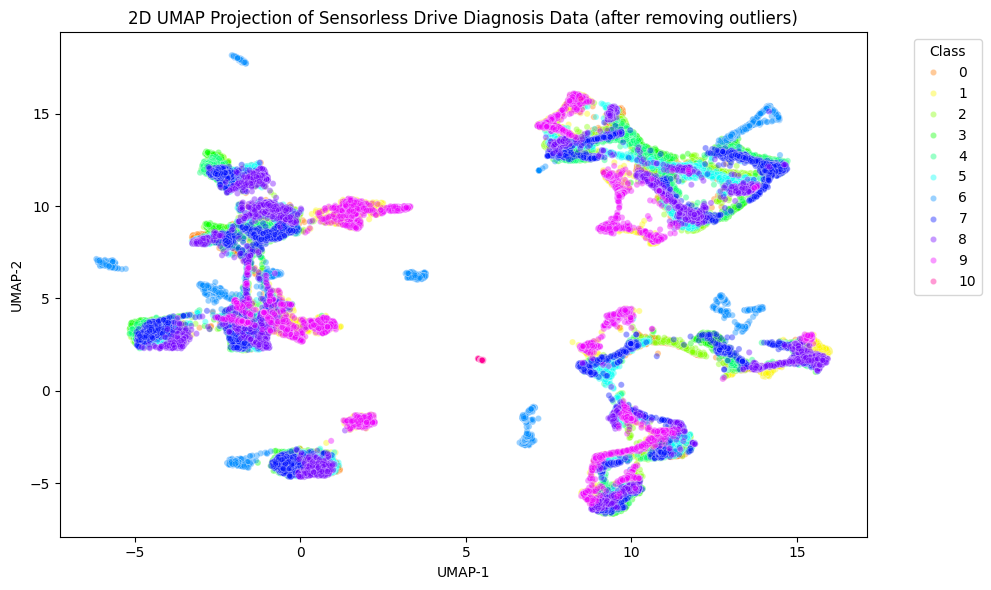

In [10]:
# reducing the dimension of 3D X_filtered to 2D for visualization with UMAP
import umap.umap_ as umap

umap_2d = umap.UMAP(n_components=2, random_state=42)
X_umap_2d = umap_2d.fit_transform(X_filtered)

df_umap_2d = pd.DataFrame(X_umap_2d, columns=['UMAP-1', 'UMAP-2'])
df_umap_2d['Class'] = y_filtered

plt.figure(figsize=(10, 6))
palette = sns.color_palette('hsv', n_colors=11)
sns.scatterplot(x='UMAP-1', y='UMAP-2', hue='Class', palette=palette, data=df_umap_2d, legend='full', s=20, alpha=0.4)
plt.title("2D UMAP Projection of Sensorless Drive Diagnosis Data (after removing outliers)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Coorelation Feature Map

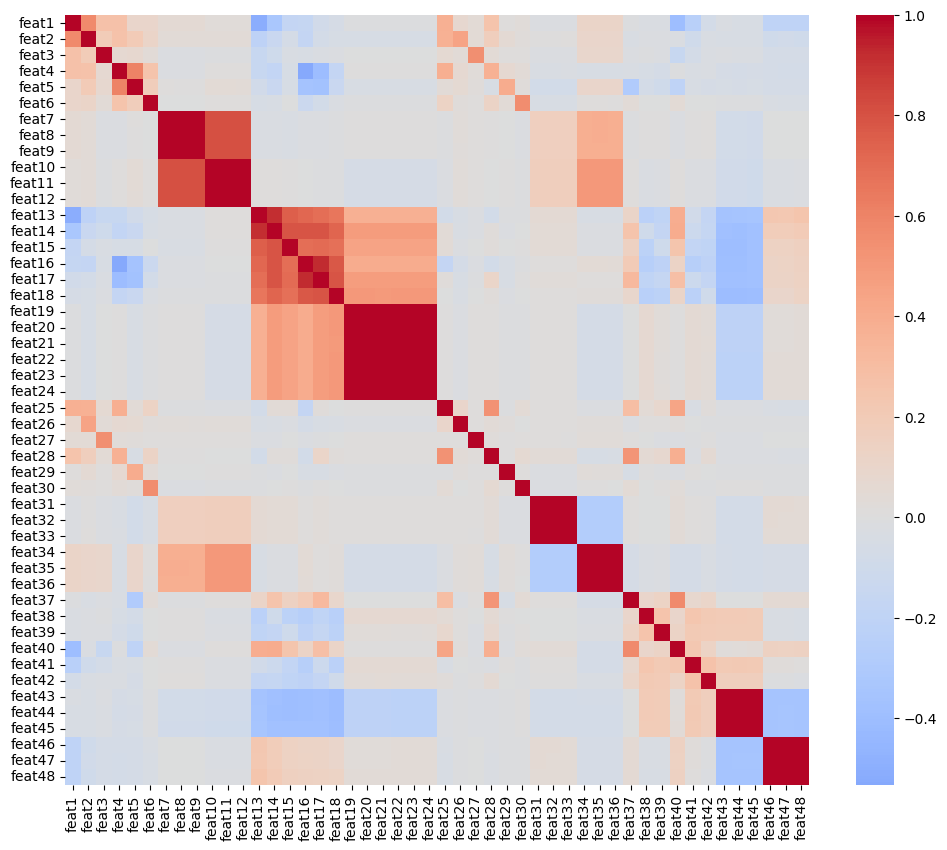

In [11]:
corr = df.drop(['class','class_enc'], axis=1).corr()
import seaborn as sns
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.show()

In [12]:
X = df.drop(columns=['class', 'class_enc'])
y = df['class_enc']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
param_grid_dt = {
    'max_depth':       [5, 10, 20, None],
    'min_samples_split': [5, 10],
    'min_samples_leaf':  [2, 4],
    'criterion':       ['gini', 'entropy'],
}
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro'
}
model = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(model, param_grid_dt, cv=3, scoring=scoring, refit='accuracy', return_train_score=True, verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters:", grid_search.best_params_)

results_dt_df = pd.DataFrame(grid_search.cv_results_)
y_pred = grid_search.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
test_recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
test_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

test_metrics_dt_df = pd.DataFrame([{
    'Test Accuracy': test_accuracy,
    'Test Precision': test_precision,
    'Test Recall': test_recall,
    'Test F1 Score': test_f1
}])

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5}
Test Accuracy: 0.9883
Test Precision: 0.9883
Test Recall: 0.9883
Test F1 Score: 0.9883


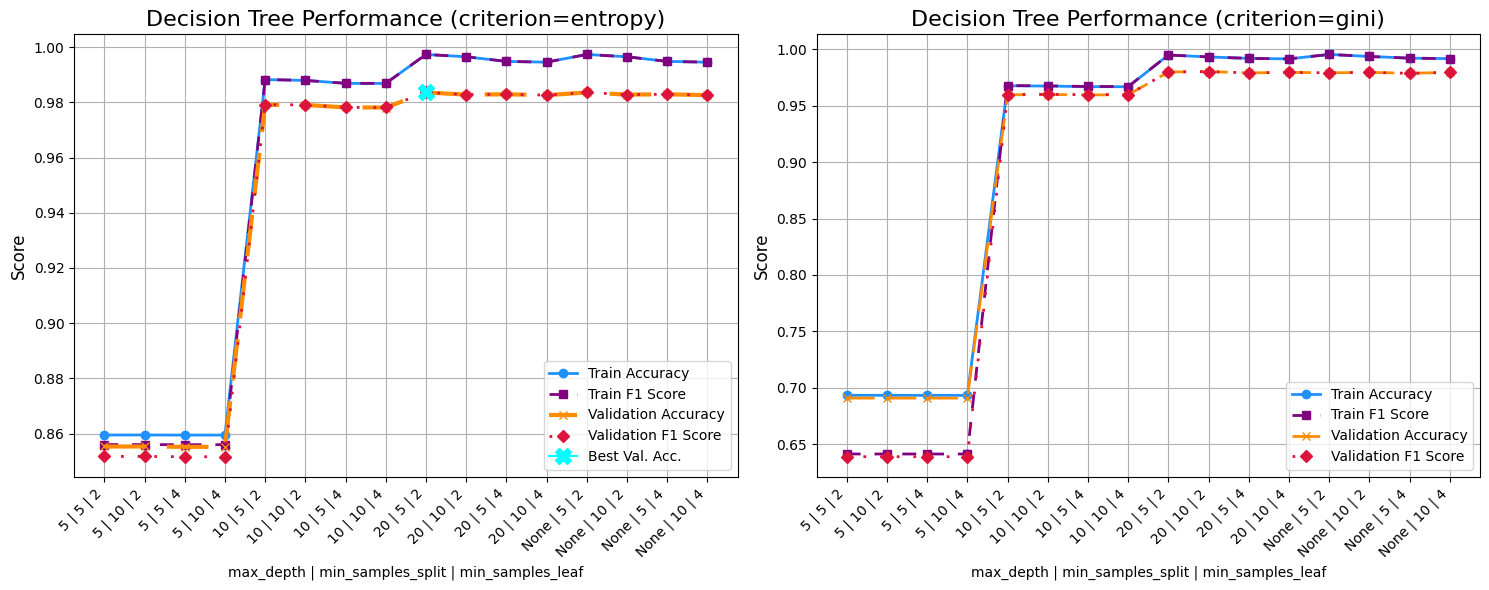

In [28]:
results_dt_df['param_combination'] = (results_dt_df['param_max_depth'].astype(str) + " | " + results_dt_df['param_min_samples_split'].astype(str) + " | " +
    results_dt_df['param_min_samples_leaf'].astype(str) + " | " + results_dt_df['param_criterion']
)
results_entropy = results_dt_df[results_dt_df['param_criterion'] == 'entropy'].copy()
results_gini = results_dt_df[results_dt_df['param_criterion'] == 'gini'].copy()

results_entropy['param_combination'] = results_entropy['param_combination'].apply(lambda x: ' | '.join(x.split(' | ')[:3]))
results_gini['param_combination'] = results_gini['param_combination'].apply(lambda x: ' | '.join(x.split(' | ')[:3]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(results_entropy['param_combination'], results_entropy['mean_train_accuracy'], linestyle='-', marker='o', label='Train Accuracy', color='dodgerblue', linewidth=2)
ax1.plot(results_entropy['param_combination'], results_entropy['mean_train_f1_macro'], linestyle='-.', dashes=(5, 5), marker='s', label='Train F1 Score', color='purple', linewidth=2)
ax1.plot(results_entropy['param_combination'], results_entropy['mean_test_accuracy'], linestyle='--', dashes=(10, 5), marker='x', label='Validation Accuracy', color='darkorange', linewidth=3)
ax1.plot(results_entropy['param_combination'], results_entropy['mean_test_f1_macro'], linestyle=':', dashes=(1, 5), marker='D', label='Validation F1 Score', color='crimson', linewidth=2)

ax1.set_title('Decision Tree Performance (criterion=entropy)', fontsize=16)
ax1.set_xlabel('max_depth | min_samples_split | min_samples_leaf', fontsize=10)
ax1.set_ylabel('Score', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
for x in ax1.get_xticklabels():
    x.set_ha('right')
ax1.legend()
ax1.grid(True)

ax2.plot(results_gini['param_combination'], results_gini['mean_train_accuracy'], linestyle='-', marker='o', label='Train Accuracy', color='dodgerblue', linewidth=2)
ax2.plot(results_gini['param_combination'], results_gini['mean_train_f1_macro'], linestyle='-.', dashes=(5, 5), marker='s', label='Train F1 Score', color='purple', linewidth=2)
ax2.plot(results_gini['param_combination'], results_gini['mean_test_accuracy'], linestyle='--', dashes=(10, 5), marker='x', label='Validation Accuracy', color='darkorange', linewidth=2)
ax2.plot(results_gini['param_combination'], results_gini['mean_test_f1_macro'], linestyle=':', dashes=(1, 5), marker='D', label='Validation F1 Score', color='crimson', linewidth=2)

ax2.set_title('Decision Tree Performance (criterion=gini)', fontsize=16)
ax2.set_xlabel('max_depth | min_samples_split | min_samples_leaf', fontsize=10)
ax2.set_ylabel('Score', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
for x in ax2.get_xticklabels():
    x.set_ha('right')
ax2.legend()
ax2.grid(True)

best_row = results_dt_df.loc[results_dt_df['mean_test_accuracy'].idxmax()]
best_combo = f"{best_row['param_max_depth']} | {best_row['param_min_samples_split']} | {best_row['param_min_samples_leaf']}"
best_score = best_row['mean_test_accuracy']

if best_row['param_criterion'] == 'entropy':
    ax1.plot(best_combo, best_score, marker='X', color='cyan', markersize=12, label='Best Val. Acc.')
else:
    ax2.plot(best_combo, best_score, marker='X', color='cyan', markersize=12, label='Best Val. Acc.')

ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

In [32]:
results_dt_df.to_csv('Final_Scripts/Final1/GS_DT.csv', index=0)
test_metrics_dt_df.to_csv('Final_Scripts/Final1/Test_DT.csv', index=0)

In [33]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'p': [1, 2],
}
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
}
model = KNeighborsClassifier()
grid_search = GridSearchCV(model, param_grid_knn, cv=3, scoring=scoring, refit='accuracy', return_train_score=True, verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters:", grid_search.best_params_)
results_knn_df = pd.DataFrame(grid_search.cv_results_)

y_pred = grid_search.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
test_recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
test_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

test_metrics_knn_df = pd.DataFrame([{
    'Test Accuracy': test_accuracy,
    'Test Precision': test_precision,
    'Test Recall': test_recall,
    'Test F1 Score': test_f1
}])

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best parameters: {'n_neighbors': 15, 'p': 1}
Test Accuracy: 0.9821
Test Precision: 0.9822
Test Recall: 0.9821
Test F1 Score: 0.9821


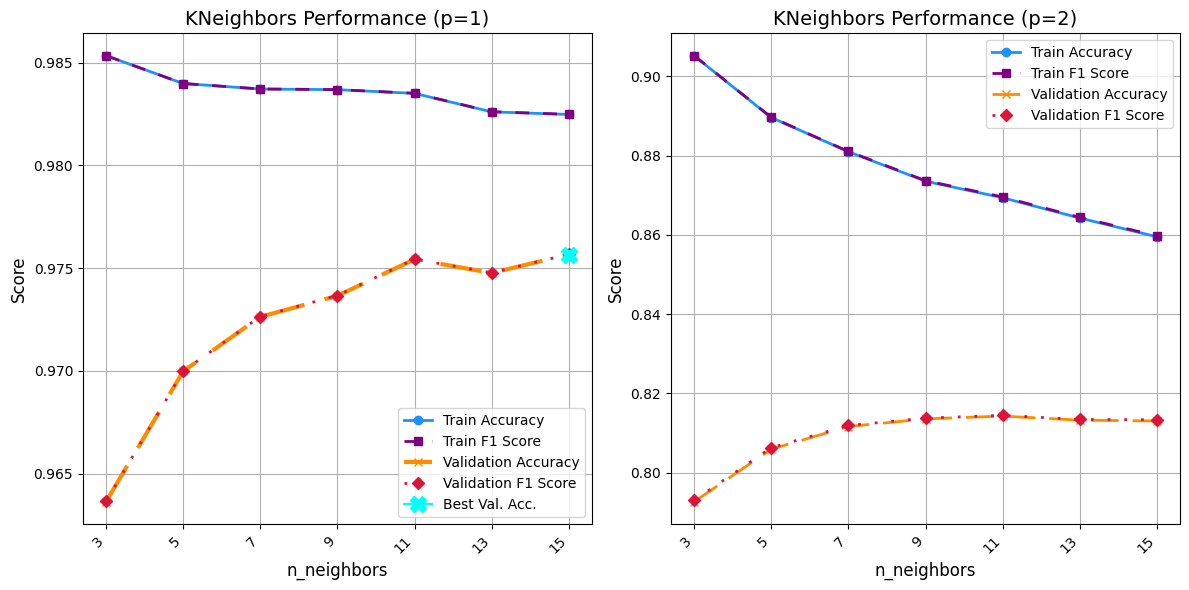

In [34]:
results_knn_df['param_combination'] = results_knn_df['param_n_neighbors'].astype(str) + " | " + results_knn_df['param_p'].astype(str)

results_p1 = results_knn_df[results_knn_df['param_p'] == 1]
results_p2 = results_knn_df[results_knn_df['param_p'] == 2]
results_p1.loc[:, 'param_combination'] = results_p1['param_combination'].apply(lambda x: ' | '.join(x.split(' | ')[:1]))
results_p2.loc[:, 'param_combination'] = results_p2['param_combination'].apply(lambda x: ' | '.join(x.split(' | ')[:1]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(results_p1['param_combination'], results_p1['mean_train_accuracy'], linestyle='-', marker='o', label='Train Accuracy', color='dodgerblue', linewidth=2)
ax1.plot(results_p1['param_combination'], results_p1['mean_train_f1_macro'], linestyle='-.', dashes=(5,5), marker='s', label='Train F1 Score', color='purple', linewidth=2)
ax1.plot(results_p1['param_combination'], results_p1['mean_test_accuracy'], linestyle='--', dashes=(10,5), marker='x', label='Validation Accuracy', color='darkorange', linewidth=3)
ax1.plot(results_p1['param_combination'], results_p1['mean_test_f1_macro'], linestyle=':', dashes=(1,5), marker='D', label='Validation F1 Score', color='crimson', linewidth=2)
ax1.set_title('KNeighbors Performance (p=1)', fontsize=14)
ax1.set_xlabel('n_neighbors', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
for tick in ax1.get_xticklabels():
    tick.set_ha('right')
ax1.legend()
ax1.grid(True)

ax2.plot(results_p2['param_combination'], results_p2['mean_train_accuracy'], linestyle='-', marker='o', label='Train Accuracy', color='dodgerblue', linewidth=2)
ax2.plot(results_p2['param_combination'], results_p2['mean_train_f1_macro'], linestyle='-.', dashes=(5,5), marker='s', label='Train F1 Score', color='purple', linewidth=2)
ax2.plot(results_p2['param_combination'], results_p2['mean_test_accuracy'], linestyle='--', dashes=(10,5), marker='x', label='Validation Accuracy', color='darkorange', linewidth=2)
ax2.plot(results_p2['param_combination'], results_p2['mean_test_f1_macro'], linestyle=':', dashes=(1,5), marker='D', label='Validation F1 Score', color='crimson', linewidth=2)
ax2.set_title('KNeighbors Performance (p=2)', fontsize=14)
ax2.set_xlabel('n_neighbors', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
for tick in ax2.get_xticklabels():
    tick.set_ha('right')
ax2.legend()
ax2.grid(True)

best_row = results_knn_df.loc[results_knn_df['mean_test_accuracy'].idxmax()]
best_n = str(best_row['param_n_neighbors'])
best_p = best_row['param_p']
best_acc = best_row['mean_test_accuracy']

if best_p == 1:
    ax1.plot(best_n, best_acc, marker='X', color='cyan', markersize=12, label='Best Val. Acc.')
    ax1.legend()
else:
    ax2.plot(best_n, best_acc, marker='X', color='cyan', markersize=12, label='Best Val. Acc.')
    ax2.legend()

plt.tight_layout()
plt.show()

In [35]:
results_knn_df.to_csv('Final_Scripts/Final1/GS_KNN.csv', index=0)
test_metrics_knn_df.to_csv('Final_Scripts/Final1/Test_KNN.csv', index=0)